In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import miceforest as mf
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sn
import lightgbm as ltb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.compose import make_column_selector
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, auc,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Replace Unknown with null value / Listwise Deletion

In [36]:
df=pd.read_csv(r'C:\Users\Joyce Huang\Downloads\BT5126 - Hands-on with Business Analytics\proposal\BankChurners.csv\BankChurners.csv')

df=df.replace('Unknown',np.NaN)
df=df.dropna()
#df.isna().sum()

### Feature engineering - add in ratio

In [21]:
# Feature engineering
df=df.drop(axis=1,columns=['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
#df['Avg_chng_amt']=df['Total_Amt_Chng_Q4_Q1']/df['Total_Ct_Chng_Q4_Q1']
df['Avg_trans_amt']=df['Total_Trans_Amt']/df['Total_Trans_Ct']
df['month_active']=12-df['Months_Inactive_12_mon']
df['Avg_contacts_per_month']=df['Contacts_Count_12_mon']/df['month_active']
df = df.drop(['Months_Inactive_12_mon','Contacts_Count_12_mon','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1'],axis=1)

### Combine divorce into Single

<AxesSubplot:xlabel='Marital_Status', ylabel='count'>

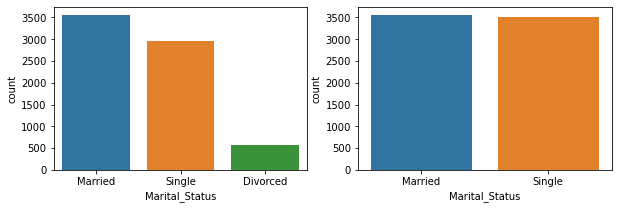

In [22]:
# Combine divorce into single
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sns.countplot(df['Marital_Status'],ax=axes[0])
df['Marital_Status'] = df['Marital_Status'].replace('Divorced','Single')
sns.countplot(df['Marital_Status'],ax=axes[1])

### One hot encoding

In [23]:
# One hot encoding
df = pd.get_dummies(df, columns=['Attrition_Flag','Gender','Marital_Status'],drop_first=True)
# print(df.columns)

### Check label class

<AxesSubplot:xlabel='Attrition_Flag_Existing Customer', ylabel='count'>

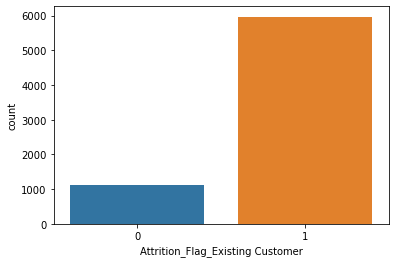

In [24]:
# Imbalanced y
sns.countplot(df['Attrition_Flag_Existing Customer'])

### set X and y

In [25]:
X = df.drop('Attrition_Flag_Existing Customer',axis=1)
y = df['Attrition_Flag_Existing Customer']

In [26]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

num_selector(X)
cat_selector(X)

['Education_Level', 'Income_Category', 'Card_Category']

### Ordinal data Label encoding / Standardization

In [33]:
label_encoder = LabelEncoder()
X['Education_Level']= label_encoder.fit_transform(X['Education_Level'])
X['Income_Category']= label_encoder.fit_transform(X['Income_Category'])
X['Card_Category']= label_encoder.fit_transform(X['Card_Category'])
#X.describe()
#print(X.columns)

scaler = StandardScaler()
df_standard = scaler.fit_transform(X)
df_standard = pd.DataFrame(df_standard)
df_standard.columns = ['Customer_Age', 'Dependent_count', 'Education_Level', 'Income_Category',
       'Card_Category', 'Months_on_book', 'Total_Relationship_Count',
       'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy',
       'Avg_Utilization_Ratio', 'Avg_trans_amt', 'month_active',
       'Avg_contacts_per_month', 'Gender_M', 'Marital_Status_Single']
display(df_standard)

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Avg_Utilization_Ratio,Avg_trans_amt,month_active,Avg_contacts_per_month,Gender_M,Marital_Status_Single
0,-0.167610,0.512710,0.285484,-0.431950,-0.259518,0.377234,0.764487,0.460058,-0.480760,0.502567,-0.794057,-1.311410,1.349309,0.126008,0.954298,-0.993384
1,0.329862,2.061228,-0.388353,1.014215,-0.259518,1.002074,1.412015,-0.025947,-0.373652,0.007308,-0.636187,-0.870016,1.349309,-0.624783,-1.047890,1.006660
2,0.578598,0.512710,-0.388353,0.291133,-0.259518,0.002330,0.116959,-0.556114,-1.437353,-0.427933,-1.012921,1.181436,1.349309,-2.126365,0.954298,-0.993384
3,-0.789449,0.512710,1.633157,-0.431950,-0.259518,-1.872192,0.764487,-0.413874,-1.437353,-0.285773,-1.012921,-1.240658,1.349309,-2.126365,0.954298,-0.993384
4,-0.291978,-0.261549,-0.388353,-1.155033,-0.259518,0.002330,-0.530569,-0.491240,0.097873,-0.499670,0.102927,-0.639269,1.349309,-0.624783,0.954298,-0.993384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7076,0.951702,-1.035808,0.285484,-0.431950,-0.259518,-0.247607,0.764487,0.596928,1.159112,0.493477,-0.471142,2.752296,0.344317,-2.126365,0.954298,1.006660
7077,1.200438,-1.035808,-0.388353,1.014215,-0.259518,1.751883,0.116959,-0.526526,-0.691285,-0.464732,-0.424499,2.194866,1.349309,0.876799,-1.047890,1.006660
7078,0.454230,-0.261549,-0.388353,-1.155033,-0.259518,0.502202,-0.530569,-0.492007,0.841479,-0.566588,0.644706,2.590091,0.344317,0.351246,0.954298,1.006660
7079,-0.291978,-1.035808,0.285484,1.014215,-0.259518,0.002330,0.764487,-0.337932,-1.437353,-0.209874,-1.012921,4.047763,-0.660674,1.544169,-1.047890,-0.993384


### Train test split / SMOTE

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36, stratify=y)

# Check class imbalance in set
print('Train purchase class = {}'.format(sum(y_train == 1)))
print('Train non purchase class = {}'.format(len(y_train) - sum(y_train == 1)))
print('Test purchase class = {}'.format(sum(y_test == 1)))
print('Test non purchase class = {}'.format(len(y_test) - sum(y_test == 1)))

Train purchase class = 4774
Train non purchase class = 890
Test purchase class = 1194
Test non purchase class = 223


In [35]:
# Over sampling
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

#check class imbalance in set
print('Train purchase class = {}'.format(sum(y_train == 1)))
print('Train non purchase class = {}'.format(len(y_train) - sum(y_train == 1)))
print('Test purchase class = {}'.format(sum(y_test == 1)))
print('Test non purchase class = {}'.format(len(y_test) - sum(y_test == 1)))

Train purchase class = 4774
Train non purchase class = 4774
Test purchase class = 1194
Test non purchase class = 223


## Single Model

In [46]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

### LightGBM

In [43]:
params = {'max_depth': [8, 10],
          'num_leaves':[40, 50],
          'learning_rate': [0.5, 1],
          }


lightgbm = LGBMClassifier(objective = 'binary',
                    metric = 'binary_logloss,auc',
                    max_depth = 6,
                    num_leaves = 40,
                    learning_rate = 0.1,
                    min_child_samples=21,
                    min_child_weight=0.001)

grid = GridSearchCV(estimator=lightgbm, param_grid=params, scoring='roc_auc', cv=5, verbose=1)

grid_result = grid.fit(X_train, y_train)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_,'\n')

lightgbm_y_pred = grid_result.predict(X_test)
print("AUC on training set: {:.3f}".format(grid_result.score(X_train, y_train)))
print("AUC on test set: {:.3f}".format(grid_result.score(X_test, y_test)),'\n')
print(classification_report(y_test, lightgbm_y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best score:  0.9754992946846862
best params:  {'learning_rate': 0.5, 'max_depth': 10, 'num_leaves': 50} 

AUC on training set: 1.000
AUC on test set: 0.864 

              precision    recall  f1-score   support

           0       0.63      0.50      0.56       223
           1       0.91      0.95      0.93      1194

    accuracy                           0.88      1417
   macro avg       0.77      0.72      0.74      1417
weighted avg       0.87      0.88      0.87      1417



### XGboost

In [44]:
params = {'max_depth':[28, 30],
      'n_estimators':[200, 250],
      'learning_rate':[0.1,0.5],
      'min_child_weight':[1, 2]
      }

xgboost = XGBClassifier(objective='binary:logistic', eval_metric="auc", n_jobs=-1 ,random_state=42)
grid = GridSearchCV(estimator=xgboost, param_grid=params, scoring='roc_auc', cv=5, verbose=1)

grid_result = grid.fit(X_train, y_train)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_,'\n')

xgboost_y_pred = grid_result.predict(X_test)
print("AUC on training set: {:.3f}".format(grid_result.score(X_train, y_train)))
print("AUC on test set: {:.3f}".format(grid_result.score(X_test, y_test)),'\n')
print(classification_report(y_test, xgboost_y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
best score:  0.9751920991352611
best params:  {'learning_rate': 0.1, 'max_depth': 30, 'min_child_weight': 1, 'n_estimators': 200} 

AUC on training set: 1.000
AUC on test set: 0.864 

              precision    recall  f1-score   support

           0       0.64      0.52      0.57       223
           1       0.91      0.94      0.93      1194

    accuracy                           0.88      1417
   macro avg       0.77      0.73      0.75      1417
weighted avg       0.87      0.88      0.87      1417



### Random Forest

In [45]:
params = {'max_depth': [30, 32],
      'n_estimators':[200, 250],
      'max_samples':[0.5, 0.9]}


clf = RandomForestClassifier(max_features='auto', criterion='entropy', bootstrap=True, n_jobs=-1, random_state=42)

grid = GridSearchCV(estimator=clf, param_grid=params, scoring='roc_auc', cv=5, verbose=1)

grid_result = grid.fit(X_train, y_train)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_,'\n')

random_forest_y_pred = grid_result.predict(X_test)
print("AUC on training set: {:.3f}".format(grid_result.score(X_train, y_train)))
print("AUC on test set: {:.3f}".format(grid_result.score(X_test, y_test)),'\n')
print(classification_report(y_test, random_forest_y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best score:  0.9745274632204225
best params:  {'max_depth': 30, 'max_samples': 0.9, 'n_estimators': 200} 

AUC on training set: 1.000
AUC on test set: 0.849 

              precision    recall  f1-score   support

           0       0.52      0.50      0.51       223
           1       0.91      0.91      0.91      1194

    accuracy                           0.85      1417
   macro avg       0.71      0.71      0.71      1417
weighted avg       0.85      0.85      0.85      1417



### Naive Bayes

In [66]:
from sklearn import metrics
clf = GaussianNB()

result = clf.fit(X_train, y_train)
nb_y_pred = result.predict(X_test)
y_pred_proba = result.predict_proba(X_test)[::,1]
y_pred_proba_train = result.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc_train = metrics.roc_auc_score(y_train, y_pred_proba_train)

print("AUC on training set: {:.3f}".format(auc_train))
print("AUC on test set: {:.3f}".format(auc,'\n'),'\n')
print(classification_report(y_test, nb_y_pred))

AUC on training set: 0.871
AUC on test set: 0.709 

              precision    recall  f1-score   support

           0       0.31      0.55      0.39       223
           1       0.90      0.77      0.83      1194

    accuracy                           0.73      1417
   macro avg       0.60      0.66      0.61      1417
weighted avg       0.81      0.73      0.76      1417



### Logistic Regressions

In [67]:
clf = LogisticRegression()

result = clf.fit(X_train, y_train)
logistic_y_pred = result.predict(X_test)
y_pred_proba = result.predict_proba(X_test)[::,1]
y_pred_proba_train = result.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc_train = metrics.roc_auc_score(y_train, y_pred_proba_train)

print("AUC on training set: {:.3f}".format(auc_train))
print("AUC on test set: {:.3f}".format(auc,'\n'),'\n')
print(classification_report(y_test, logistic_y_pred))

AUC on training set: 0.755
AUC on test set: 0.652 

              precision    recall  f1-score   support

           0       0.26      0.55      0.35       223
           1       0.89      0.70      0.79      1194

    accuracy                           0.68      1417
   macro avg       0.58      0.63      0.57      1417
weighted avg       0.79      0.68      0.72      1417



## Stacking

In [72]:
from sklearn.ensemble import StackingClassifier

models = [('lightgbm', LGBMClassifier(objective = 'binary',
                    metric = 'binary_logloss,auc',
                    max_depth = 10,
                    num_leaves = 50,
                    learning_rate = 0.5,
                    min_child_samples=21,
                    min_child_weight=0.001)),
          ('xgboost', RandomForestClassifier(max_features='auto', 
                                            criterion='entropy',
                                            max_depth=30,
                                            max_samples=0.9,
                                            n_estimators=200,
                                            bootstrap=True, 
                                            n_jobs=-1, 
                                            random_state=42))]

stacking = StackingClassifier(estimators=models, final_estimator=XGBClassifier(objective='binary:logistic', 
                                                                               eval_metric="auc", 
                                                                               n_jobs=-1,
                                                                               random_state=42,
                                                                               learning_rate=0.1,
                                                                               max_depth=30,
                                                                               min_child_weight=1,
                                                                               n_estimators=200))

stacking

StackingClassifier(estimators=[('lightgbm',
                                LGBMClassifier(learning_rate=0.5, max_depth=10,
                                               metric='binary_logloss,auc',
                                               min_child_samples=21,
                                               num_leaves=50,
                                               objective='binary')),
                               ('xgboost',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=30,
                                                       max_samples=0.9,
                                                       n_estimators=200,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=XGBClassifier(base_score=None, bo...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_delta_step=None,
                                                 max_depth=30,
                                                 min_child_weight=1,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=200, n_jobs=-1,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=42,
                                                 reg_alpha=None,
                                                 reg_lambda=None,
                                                 scale_pos_weight=None,
                                                 subsample=None,
                                                 tree_method=None,
                                                 validate_parameters=None,
                                                 verbosity=None))

In [76]:
result = stacking.fit(X_train, y_train)

In [75]:
y_pred = stacking.predict(X_test)

In [78]:
y_pred_proba = result.predict_proba(X_test)[::,1]
y_pred_proba_train = result.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc_train = metrics.roc_auc_score(y_train, y_pred_proba_train)

print("AUC on training set: {:.3f}".format(auc_train))
print("AUC on test set: {:.3f}".format(auc,'\n'),'\n')
print(classification_report(y_test, y_pred))

AUC on training set: 1.000
AUC on test set: 0.815 

              precision    recall  f1-score   support

           0       0.55      0.41      0.47       223
           1       0.90      0.94      0.92      1194

    accuracy                           0.85      1417
   macro avg       0.72      0.67      0.69      1417
weighted avg       0.84      0.85      0.85      1417



### XGboost single model is the best